# Liberty Project

This notebook will demonstrate the work I have done for a data science project as part of the interview process for Liberty Oilfield Services <br>
<br>
The following are the objective and 5 guidelines to deliver on that objective: <br>
<br>

> Develop a machine learning pipeline that:
> 1. Ingests temperature telemetry data from an external API in real-time.
> 2. Performs exploratory data analysis to understand the data.
> 3. Builds a model to predict the temperature for the next hour.
> 4. Continuously evaluates and updates the model as new data becomes available.
> 5. Generates alerts when the predicted temperature exceeds a threshold.


## 0. Preparation

First, I want to get all of the previous data I can. According the documentation, 92 days is the maximum.

In [3]:
!pip install schedule

In [4]:
# Standard library imports
from datetime import datetime
import warnings

# Third-party imports
import requests
import schedule
from schedule import repeat, every, run_pending
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, r2_score

In [5]:
# Ignoring warnings
warnings.filterwarnings('ignore') 

In [6]:
# Defining parameters
# These are the points of longitude and latitude requested in the project instructions
# 'minutely_15' specifies that we want data points from every 15 minutes 
# For this particular step I just want past, real data. Not forecast.
weather_params = {
    "latitude": 35.49,
    "longitude": -97.96,
    "temperature_unit": "fahrenheit",
    "minutely_15": ["temperature_2m",
                    "relative_humidity_2m",
                    "dew_point_2m",
                    "wind_speed_10m",
                    "wind_speed_80m",
                    "wind_direction_10m",
                    "wind_direction_80m"],
    "forecast_minutely_15": 0,
    "past_minutely_15": 8832 # Max number of temp. data in 15-min increments
}



# Making the request and capturing it's response
response = requests.get("https://api.open-meteo.com/v1/forecast", params=weather_params)

In [7]:
# Getting the data from the response
past_temp_data = response.json()['minutely_15']

The output is vast for this, so I won't give any output until we get this into a dataframe.

In [8]:
# Converting JSON into a pandas dataframe
df = pd.DataFrame(past_temp_data)

In [9]:
# Taking a look at the dataframe
df

,time,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,wind_speed_80m,wind_direction_10m,wind_direction_80m
0,2024-11-24T00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-24T00:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-11-24T00:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-11-24T00:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-11-24T01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
8827,2025-02-23T22:45,65.9,27.0,31.0,15.1,17.9,205.0,205.0
8828,2025-02-23T23:00,66.3,28.0,32.2,16.3,19.2,202.0,203.0
8829,2025-02-23T23:15,65.9,29.0,32.7,15.0,18.9,210.0,211.0
8830,2025-02-23T23:30,64.6,31.0,33.3,12.7,18.2,209.0,210.0


In [10]:
# For some reason, some of the earliest data points are missing. I will remove them before writing the csv.
df_without_nans = df[df['temperature_2m'].notna()]

In [11]:
# Writing the CSV
df_without_nans.to_csv("/kaggle/working/past_telemetry_data.csv", index=False)

## 1. Data Ingestion

In [12]:
# Formatting parameters to get only the previous 15 minutes' temperature
weather_params = {
    "latitude": 35.49,
    "longitude": -97.96,
    "temperature_unit": "fahrenheit",
    "minutely_15": ["temperature_2m",
                    "relative_humidity_2m",
                    "dew_point_2m",
                    "wind_speed_10m",
                    "wind_speed_80m",
                    "wind_direction_10m",
                    "wind_direction_80m"],
    "past_minutely_15": 1,
    "forecast_minutely_15": 0
    
}



def get_15_minutely_temp(params=weather_params):
    # Making the request and capturing it's response
    response = requests.get("https://api.open-meteo.com/v1/forecast", params=params)
    new_data = pd.DataFrame(response.json()['minutely_15'])

    # Loading in telemetry data
    all_data = pd.read_csv("/kaggle/working/past_telemetry_data.csv")
    
    # Appending new data to end of all data
    all_data = pd.concat([all_data, new_data])

    all_data.to_csv("/kaggle/working/current_telemetry_data.csv", index=False)
    print("Ran!")

# Using Python's 'schedule' library to schedule a run every 15 minutes
schedule.every(15).minutes.do(get_15_minutely_temp)

Every 15 minutes do get_15_minutely_temp() (last run: [never], next run: 2025-02-24 22:08:42)

In [13]:
# while True:
#     # Running the function to get API data every 15 minutes
#     schedule.run_pending()

This code will now send a request to the API every 15 minutes and get data back.

## 2. Exploratory Data Analysis

In [14]:
df = pd.read_csv("/kaggle/working/past_telemetry_data.csv")

In [15]:
# Converting ISO 8162 to Unix timestamp for python operations
df['time'] = pd.to_datetime(df['time'])

In [16]:
# Doing some data manipulation to get it ready for plotting
df['day'] = [t.day for t in df['time']]
df['hour'] = [t.hour for t in df['time']]
df['month'] = [t.month for t in df['time']]
df['date'] = [t.date() for t in df['time']]
df['time_of_day'] = [int(t.time().strftime("%H%M")) for t in df['time']]

<Axes: xlabel='hour', ylabel='temperature_2m'>

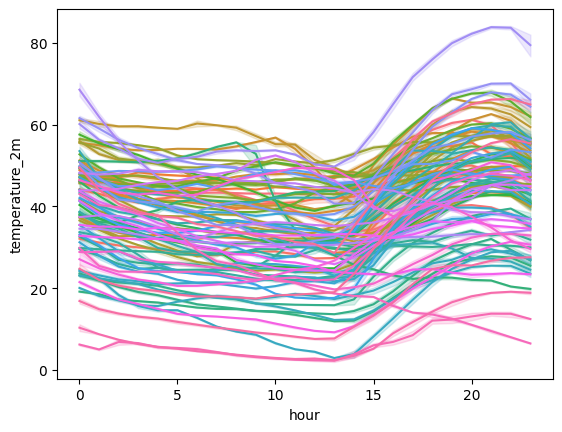

In [17]:
sns.lineplot(df, x="hour", y="temperature_2m", hue="date", legend=False)

It seems to follow a sinusoidal pattern, with the trough during the middle of the day.

There are a few notable outliers, however. One day was abnormally hot during the winter months; another dipped well below the all of the other days in temperature; one day even saw temperatures decrease as the hours increased.

Looking at the same plot, but with hue separated by month.

<Axes: xlabel='hour', ylabel='temperature_2m'>

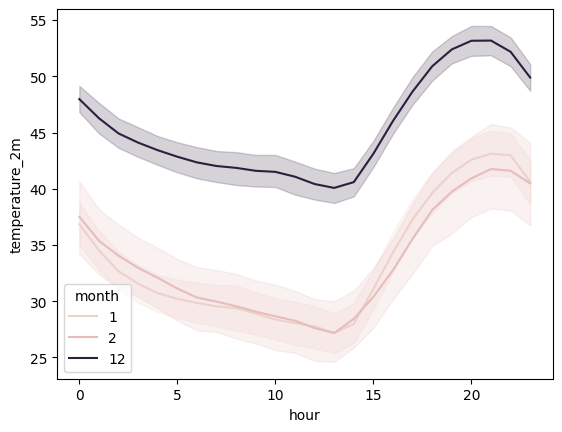

In [18]:
sns.lineplot(df, x="hour", y="temperature_2m", hue="month", legend=True)

Let's look at month now

Very consistent trend for times of day, with another fairly predictable trend for months of the year

Finally, I want to look at each of the non-temperature measurements over the same time period, and how they correlate to temperature.

<Axes: xlabel='time', ylabel='temperature_2m'>

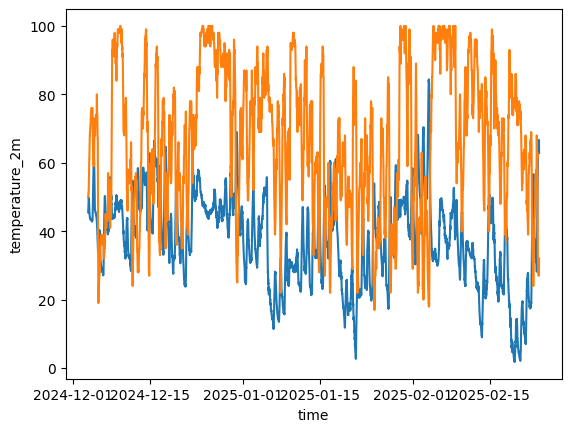

In [20]:
sns.lineplot(df, x="time", y="temperature_2m")
sns.lineplot(df, x="time", y="relative_humidity_2m")

<Axes: >

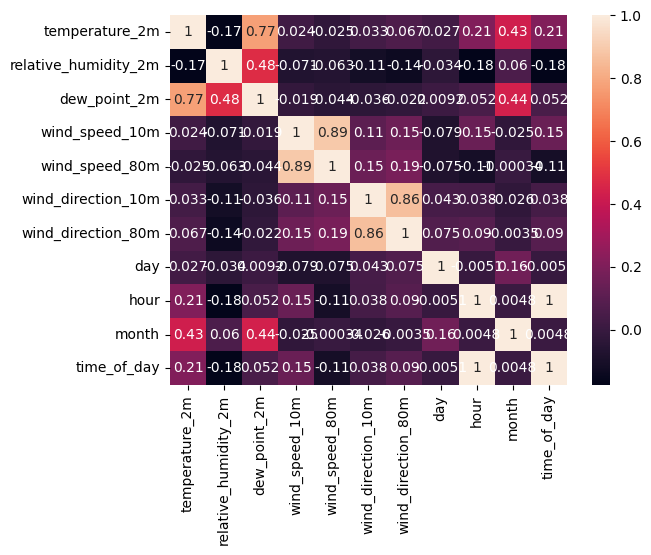

In [21]:
sns.heatmap(df.drop(columns=["time", "date"]).corr(), annot=True)

To my surprise, most of these variables do not correlate with each other, and only dew point seems to correlate with temperature.

<Axes: xlabel='dew_point_2m', ylabel='temperature_2m'>

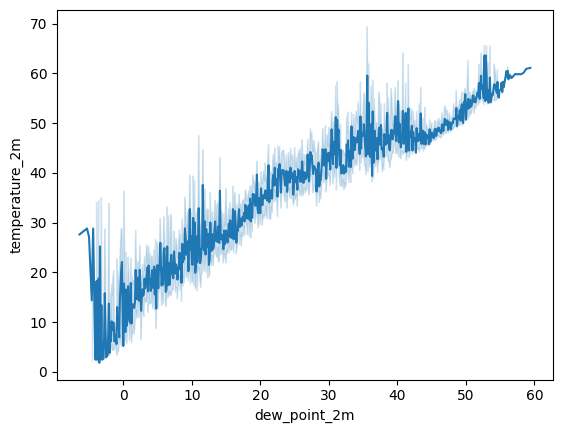

In [22]:
# Just for fun, plotting temp as a function of dew point
sns.lineplot(df, x="dew_point_2m", y="temperature_2m")

In [23]:
# Average Temperature by hour of day
df[['temperature_2m', 'hour']].groupby(by=["hour"]).mean()

,temperature_2m
hour,
0,40.835671
1,38.776220
2,37.237805
3,36.235061
4,35.440549
5,34.783232
6,34.248171
7,33.922256
8,33.691768


It looks like `hour` will be a good feature for our model

In [24]:
# Average Temperature by month
df[['temperature_2m', 'month']].groupby(by=["month"]).mean()

,temperature_2m
month,
1,33.608300
2,33.478668
12,45.488479


`Month` also seems to be important, and this makes sense with our knowledge of seasons

In [25]:
# Average Temperature by day of month
df[['temperature_2m', 'day']].groupby(by=["day"]).mean()

,temperature_2m
day,
1,39.466667
2,46.488542
3,48.820283
4,43.971181
5,37.345486
6,32.590972
7,34.442014
8,38.685069
9,37.343750


These numbers do not follow any sort of pattern, so it follows that `day` is not a good feature.

## 3. Model Development

The features I will use for this model training are `month` and `hour`.

I will also engineer some features, like the temperature from 15 minutes ago and perhaps the previous day

In general, I favor XGBoost for its robust ability to handle an array of use cases. However, I am curious if a neural network might out-perform the regression model. <br>
<br>
My initial thought is that, with the lack of data available, deep learning may be overkill.

### Feature Engineering

In [26]:
# getting the temperature from the previous 15, 30, 45 minutes, and 1 hour
df['previous_15_min_temp'] = df['temperature_2m'].shift(1)
df['previous_30_min_temp'] = df['temperature_2m'].shift(2)
df['previous_45_min_temp'] = df['temperature_2m'].shift(3)
df['previous_1_hour_temp'] = df['temperature_2m'].shift(4)
df['previous_15_dew_point'] = df['dew_point_2m'].shift(1)

df = df.dropna()

### Model Fitting

I am going to test with two models: `XGBRegression` and `Artificial Neural Network`

With both of these models I will test several different feature combinations.

To evaluate, I will use `Mean Absolute Error (MAE)` and `R-Squared Score`

In [27]:
# Splitting data into training and testing
df_test = df.query("month == 2 and day >= 10")
df_train = df.loc[~df.index.isin(df_test.index)]


model_types = ["xgb", "nn"]
feature_combos = [["hour", "month"],
                 ['previous_15_min_temp'],
                 ['hour', 'month', 'previous_15_min_temp'],
                 ['hour', 'month', 'previous_15_min_temp', 'previous_30_min_temp'],
                 ['hour', 'month', 'previous_15_min_temp', 'previous_30_min_temp', 'previous_45_min_temp'],
                 ['hour', 'month', 'previous_15_min_temp', 'previous_30_min_temp', 'previous_45_min_temp', 'previous_1_hour_temp'],
                 ['hour', 'month', 'previous_15_min_temp', 'previous_30_min_temp', 'previous_45_min_temp', 'previous_1_hour_temp', 'dew_point_2m'],
                 ['hour', 'month', 'previous_15_min_temp', 'dew_point_2m']]

# Df to store results for comparison
results = pd.DataFrame()
y_preds = []
y_tests = []

# Setting random seed for reliable results
tf.random.set_seed(1234)

for model_name in model_types:
    for x_cols in feature_combos:
        print("MODEL:", model_name, " ", "COLS:", x_cols)
        # Separating x, y, training and testing data
        y_col = ['temperature_2m']
        
        x_train = df_train[x_cols]
        y_train = df_train[y_col]
        x_test = df_test[x_cols]
        y_test = df_test[y_col]

        if model_name == "xgb":
            # Create XGBoost classifier
            model = xgb.XGBRegressor()
            
            # Fit model to November, December, and January data
            model.fit(x_train, y_train)

            # Getting model predictions on test data
            y_pred = model.predict(x_test)

            # Getting metrics
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # saving array of values for plotting
            y_preds.append(y_pred)
            y_tests.append(y_test)

        elif model_name == 'nn':
            # Create ANN
            model = tf.keras.models.Sequential([
                      # tf.keras.layers.Flatten(input_shape=(28, 28)),
                      tf.keras.layers.Dense(128, activation='relu'),
                      #tf.keras.layers.Dropout(0.2),
                      tf.keras.layers.Dense(1, activation='relu')
                    ])
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                          loss='mean_absolute_error')
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)

            # Getting metrics
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # saving array of values for plotting
            y_preds.append(y_pred)
            y_tests.append(y_test)

        # Appending results to df
        results_dict = {
            "model": model_name,
            "features": str(x_cols),
            "mae": mae,
            "r2": r2
        }
        results = pd.concat([results, pd.DataFrame(results_dict, index=[str(model_name) + str(x_cols)])])

results = results.reset_index(drop=True)


MODEL: xgb   COLS: ['hour', 'month']
MODEL: xgb   COLS: ['previous_15_min_temp']
MODEL: xgb   COLS: ['hour', 'month', 'previous_15_min_temp']
MODEL: xgb   COLS: ['hour', 'month', 'previous_15_min_temp', 'previous_30_min_temp']
MODEL: xgb   COLS: ['hour', 'month', 'previous_15_min_temp', 'previous_30_min_temp', 'previous_45_min_temp']
MODEL: xgb   COLS: ['hour', 'month', 'previous_15_min_temp', 'previous_30_min_temp', 'previous_45_min_temp', 'previous_1_hour_temp']
MODEL: xgb   COLS: ['hour', 'month', 'previous_15_min_temp', 'previous_30_min_temp', 'previous_45_min_temp', 'previous_1_hour_temp', 'dew_point_2m']
MODEL: xgb   COLS: ['hour', 'month', 'previous_15_min_temp', 'dew_point_2m']
MODEL: nn   COLS: ['hour', 'month']
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 40.0174
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MODEL: nn   COLS: ['previous_15_min_temp']
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 40.0174
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MODEL: nn   COLS: ['hour', 'month'

In [28]:
results.reset_index(drop=True).sort_values(by="mae")

,model,features,mae,r2
15,nn,"['hour', 'month', 'previous_15_min_temp', 'dew...",0.574743,0.996540
10,nn,"['hour', 'month', 'previous_15_min_temp']",0.576643,0.996909
13,nn,"['hour', 'month', 'previous_15_min_temp', 'pre...",0.699073,0.995098
1,xgb,['previous_15_min_temp'],0.710570,0.994115
11,nn,"['hour', 'month', 'previous_15_min_temp', 'pre...",0.725554,0.995432
6,xgb,"['hour', 'month', 'previous_15_min_temp', 'pre...",0.729189,0.993725
5,xgb,"['hour', 'month', 'previous_15_min_temp', 'pre...",0.770924,0.992235
4,xgb,"['hour', 'month', 'previous_15_min_temp', 'pre...",0.775499,0.992100
14,nn,"['hour', 'month', 'previous_15_min_temp', 'pre...",0.792050,0.993380
7,xgb,"['hour', 'month', 'previous_15_min_temp', 'dew...",0.792365,0.992672


In [29]:
results.reset_index(drop=True).sort_values(by="r2", ascending=False)

,model,features,mae,r2
10,nn,"['hour', 'month', 'previous_15_min_temp']",0.576643,0.996909
15,nn,"['hour', 'month', 'previous_15_min_temp', 'dew...",0.574743,0.996540
11,nn,"['hour', 'month', 'previous_15_min_temp', 'pre...",0.725554,0.995432
13,nn,"['hour', 'month', 'previous_15_min_temp', 'pre...",0.699073,0.995098
1,xgb,['previous_15_min_temp'],0.710570,0.994115
6,xgb,"['hour', 'month', 'previous_15_min_temp', 'pre...",0.729189,0.993725
14,nn,"['hour', 'month', 'previous_15_min_temp', 'pre...",0.792050,0.993380
7,xgb,"['hour', 'month', 'previous_15_min_temp', 'dew...",0.792365,0.992672
12,nn,"['hour', 'month', 'previous_15_min_temp', 'pre...",0.857451,0.992593
5,xgb,"['hour', 'month', 'previous_15_min_temp', 'pre...",0.770924,0.992235


In [30]:
results.iloc[6]['features']

"['hour', 'month', 'previous_15_min_temp', 'previous_30_min_temp', 'previous_45_min_temp', 'previous_1_hour_temp', 'dew_point_2m']"

After running this loop to test model + feature combinations, it appears the XGBoost Regression model is decisely the better choice, with all features I originally identified as the feature vector.

## 4. Real-Time Evaluation and Model Update

Now that the model has been fit and saved, we can make forecasts about future data.

We can also take the new data and re-fit the model, so that our model gradually becomes more robust.

Below, I've written some functions to achieve this process:

In [ ]:
# Constants
# Formatting parameters to get only the previous 15 minutes' temperature
WEATHER_PARAMS = {
    "latitude": 35.49,
    "longitude": -97.96,
    "temperature_unit": "fahrenheit",
    "minutely_15": "temperature_2m",
    "past_minutely_15": 1,
    "forecast_minutely_15": 0
    
}
NEWEST_WEATHER_DATA_PATH = "/kaggle/working/current_telemetry_data.csv"
ORIGINAL_WEATHER_DATA_PATH = "/kaggle/working/past_telemetry_data.csv"
MODEL_SAVE_PATH = "weather_model.json"
API_URL = "https://api.open-meteo.com/v1/forecast"


@repeat(every(15).minutes)
def get_15_minutely_temp(params=WEATHER_PARAMS,
                         original_data_path=ORIGINAL_WEATHER_DATA_PATH,
                         newest_data_path=NEWEST_WEATHER_DATA_PATH):
    # Making the request and capturing it's response
    # api url will not change, so not adding it as an optional arg
    response = requests.get(API_PATH, params=params)
    new_data = pd.DataFrame(response.json()['minutely_15'])

    # Loading in telemetry data
    all_data = pd.read_csv(original_data_path)
    
    # Appending new data to end of all data
    all_data = pd.concat([all_data, new_data])

    all_data.to_csv(newest_data_path, index=False)
    print("Ran!")

    
def fit_xgb_regression_model(df_path=NEWEST_WEATHER_DATA_PATH,
                             model_save_path=MODEL_SAVE_PATH):

    # Loading dataset with newest data
    df = pd.read_csv(df_path)
    
    # Converting ISO 8162
    df['time_of_day'] = [int(t.time().strftime("%H%M")) for t in df['time']]
    
    # Extracting hour and month from timestamp
    df['hour'] = [t.hour for t in df['time']]
    df['month'] = [t.month for t in df['time']]
    
    # getting the temperature from the previous 15 minutes
    df['previous_15_min_temp'] = df['temperature_2m'].shift(1)
    
    # Separating x, y, training and testing data
    x_cols = ['hour', 'month', 'previous_15_min_temp']
    y_col = ['temperature_2m']

    x = df[x_cols]
    y = df[y_col]

    # Create XGBoost classifier
    model = xgb.XGBRegressor()
    
    # Fit model to November, December, and January data
    model.fit(x, y)

    model.save_model("weather_model.json")

I'm leveraging the `schedule` library to incrementally ingest temperature data from the API.

In [ ]:
while True:
    # Running the function to get API data every 15 minutes
    run_pending()

    # Loading in updated dataset
    df = pd.read_csv("/kaggle/working/current_telemetry_data.csv")

    # fitting new model
    fit_xgb_regression_model()

## 5: Alert System

Weather can produce anomalies. It is imperative that we alert the necessary people of an unusually high or low temperature projection.

See project for implementation of step 5

## Further Improvements Given Time

- Spend more time tuning hyperparameters, especially for ANN.
- Leverage AWS or equivalent cloud service for scheduling to limit downtime
- Add argument parsing to project to allow potential user to pass custom file paths/temperature thresholds.
   - Or project config file; Refactor code to not force user to edit code
- Created requirements.txt so user could run program locally without dependency issues